## Stock News Sentiment Analysis using Vader and BERT

In the notebook, I have scraped the website, FinViz, to get the news articles associated with a company's stock. I have divided the notebook in the following parts. 

- Importing the libraraies
- Instantiating the url and tickers
- Using beautiful soup to extract the data from the website
- Using vader to understand the snetiment of the stock news
- Plotting the sentiment of each of the stocks

In [12]:
#Importing the libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
#Instantiating the finviz url and setting up the tickers
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMZN', 'GOOG', 'FB']

#Instantiating the news_tables dictionary
news_tables = {}

#Looping through the tickers
for ticker in tickers:
    #Setting up the full url
    url = finviz_url + ticker
    #Running the request and saving the response
    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)
    #Using beautiful soup to parse the text
    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

In [14]:
#Instantiating the parsed_data dictionary
parsed_data = []

#Looping throught the news_table
for ticker, news_table in news_tables.items():

    for row in news_table.findAll('tr'):

        title = row.a.text
        date_data = row.td.text.split(' ')

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, title])

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
df

,ticker,date,time,title
0,AMZN,May-26-22,06:33PM,Why AMD Stock Popped Today
1,AMZN,May-26-22,05:29PM,"Apple Memorial Day Deals: Save on Apple Watch,..."
2,AMZN,May-26-22,04:55PM,Broadcom to Buy VMware for $61 Billion in Reco...
3,AMZN,May-26-22,04:23PM,"Stocks bounce back from market sell-off, consu..."
4,AMZN,May-26-22,04:09PM,"Walmart, Target pressured to compensate employ..."
...,...,...,...,...
295,FB,May-20-22,09:14AM,Michael Burrys 2022 Portfolio: Top 10 Stock Picks
296,FB,May-20-22,09:05AM,10 Best Buy-the-Dip Tech Stocks According to B...
297,FB,May-20-22,08:21AM,Meta bans employees from talking about abortion
298,FB,May-20-22,06:44AM,Missed Out on Meta Platforms? 2 Growth Stocks ...


## Vader

In [15]:
#Passing the news headlines data through vader (Sentiment Analyser)
vader = SentimentIntensityAnalyzer()

#Calculating the sentiment scores using vader
f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)
df['date'] = pd.to_datetime(df.date).dt.date
df.head()

,ticker,date,time,title,compound
0,AMZN,2022-05-26,06:33PM,Why AMD Stock Popped Today,0.0000
1,AMZN,2022-05-26,05:29PM,"Apple Memorial Day Deals: Save on Apple Watch,...",0.4939
2,AMZN,2022-05-26,04:55PM,Broadcom to Buy VMware for $61 Billion in Reco...,0.0000
3,AMZN,2022-05-26,04:23PM,"Stocks bounce back from market sell-off, consu...",0.3400
4,AMZN,2022-05-26,04:09PM,"Walmart, Target pressured to compensate employ...",-0.2263


<Figure size 864x720 with 0 Axes>

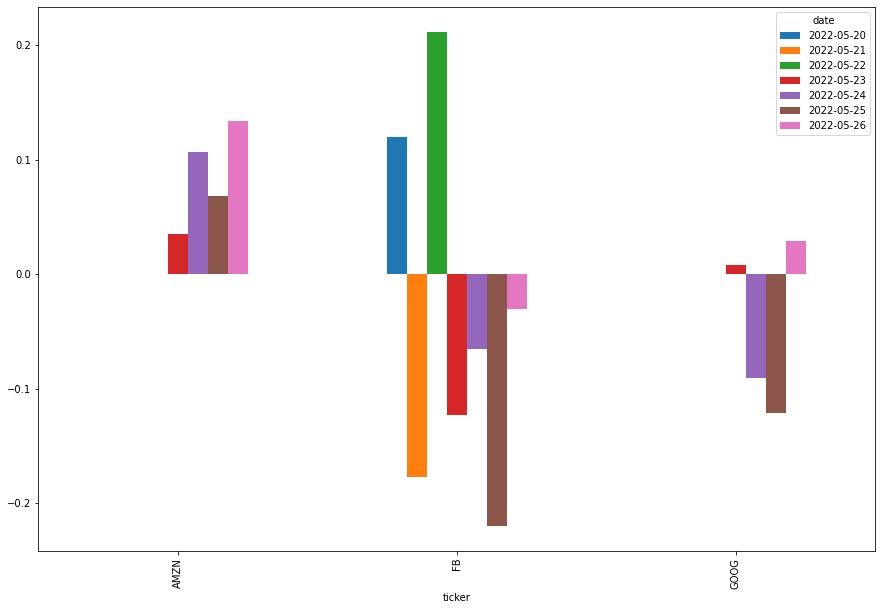

In [16]:
#Plotting the stock and the sentiment polarity
fig = plt.figure() 
fig.set_size_inches(12,10)
mean_df = df.groupby(['ticker', 'date']).mean().unstack()
mean_df = mean_df.xs('compound', axis="columns")
mean_df.plot(kind='bar')
plt.show()
plt.rcParams['figure.figsize'] = [15, 10]

## Using BERT to calculate sentiments

In this section, I will be using the pre-trained BERT SEntiment Analyser to get the sentiment of the news articles. The BERT gives the sentiment in a range from 1 to 5. I will be using the hugging face transformer library to implement the solution. 

In [17]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [18]:
!pip install transformers requests beautifulsoup4 pandas numpy

In [19]:
#Importing the librairies from transformers libarry
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#Importing torch
import torch
#Importing requests to scrape the website
import requests
#Importing beautiful soup to scrape the website
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np

In [20]:
#Importing the AutoTokenizer module from the pre-trained BERT model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

#Instantiating the model from the AutoModelForSequenceClassificationmodule of the pre-trained BERT Model
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [21]:
#Defining the function, to tokenize the string and calculate the snetiment of the string
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [22]:
df['bert_sentiment'] = df['title'].apply(lambda x: sentiment_score(x[:512]))
df

,ticker,date,time,title,compound,bert_sentiment
0,AMZN,2022-05-26,06:33PM,Why AMD Stock Popped Today,0.0000,5
1,AMZN,2022-05-26,05:29PM,"Apple Memorial Day Deals: Save on Apple Watch,...",0.4939,1
2,AMZN,2022-05-26,04:55PM,Broadcom to Buy VMware for $61 Billion in Reco...,0.0000,5
3,AMZN,2022-05-26,04:23PM,"Stocks bounce back from market sell-off, consu...",0.3400,1
4,AMZN,2022-05-26,04:09PM,"Walmart, Target pressured to compensate employ...",-0.2263,1
...,...,...,...,...,...,...
295,FB,2022-05-20,09:14AM,Michael Burrys 2022 Portfolio: Top 10 Stock Picks,0.2023,5
296,FB,2022-05-20,09:05AM,10 Best Buy-the-Dip Tech Stocks According to B...,0.6369,5
297,FB,2022-05-20,08:21AM,Meta bans employees from talking about abortion,0.0000,1
298,FB,2022-05-20,06:44AM,Missed Out on Meta Platforms? 2 Growth Stocks ...,0.1027,5


<Figure size 864x720 with 0 Axes>

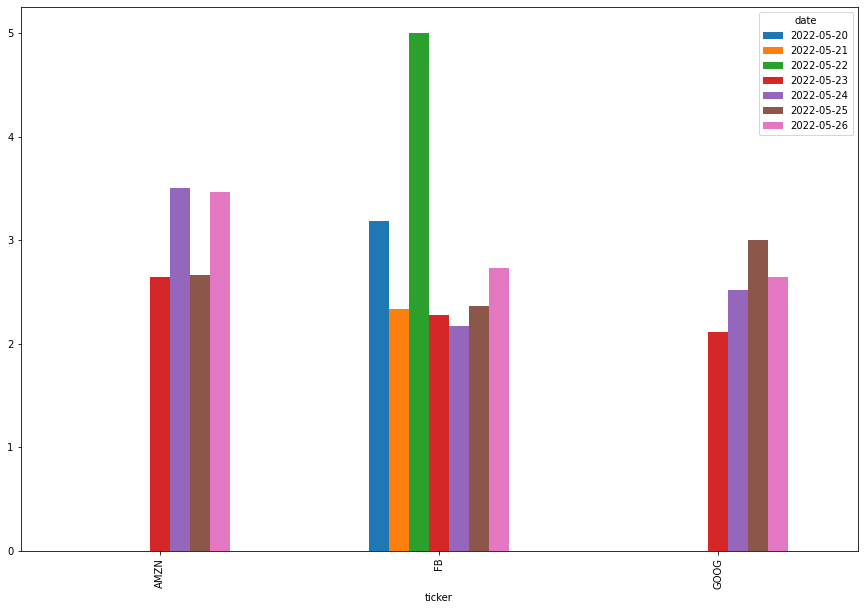

In [23]:
#Plotting the stock and the sentiment polarity
fig = plt.figure() 
fig.set_size_inches(12,10)
mean_df = df.groupby(['ticker', 'date']).mean().unstack()
mean_df = mean_df.xs('bert_sentiment', axis="columns")
mean_df.plot(kind='bar')
plt.show()
plt.rcParams['figure.figsize'] = [15, 10]